In [11]:

from utils.trainfiles import TrainFiles
from utils.dataloader import DataLoader
from model.unet import UNet

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    print('GPU ready')
else:
    print('Warning: only CPU found')

GPU ready


# Generate trainfiles.json

In [2]:
trainfiles = TrainFiles('trainfiles.yaml',True)
trainfiles.find_files('/home/stephan/Desktop/',['.stk'], 4, 16)

# Train UNet

In [8]:
trainfiles = TrainFiles('trainfiles.json',False)
dataloader = DataLoader(trainfiles,batch_size=6,n_pre=2,n_post=2,train_height=400,train_width=400,load_multiple_targets_per_file=True,n_multiple_targets=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(dataloader.n_pre + dataloader.n_post).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.L1Loss()


In [9]:
# Training loop
num_epochs = 1
for epoch in range(num_epochs):
    i = 0
    while not dataloader.epoch_done:
        batch_generated = dataloader.get_batch()
        if not batch_generated:
            break
        data = dataloader.X.to(device)
        targets = dataloader.y.to(device)
        model.train()
        outputs = model(data)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Batch {i+1} (samples {(i+1)*dataloader.batch_size}), Loss: {loss.item()}')
        i += 1
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    dataloader.shuffle_array()

Batch 1 (samples 6), Loss: 0.6909609436988831
Batch 11 (samples 66), Loss: 0.27553391456604004
Batch 21 (samples 126), Loss: 0.2531118392944336
Batch 31 (samples 186), Loss: 0.26683464646339417
Batch 41 (samples 246), Loss: 0.31963130831718445
Batch 51 (samples 306), Loss: 0.24245847761631012
Batch 61 (samples 366), Loss: 0.22504113614559174
Batch 71 (samples 426), Loss: 0.20224836468696594
Batch 81 (samples 486), Loss: 0.23596012592315674
Batch 91 (samples 546), Loss: 0.25659382343292236
Batch 101 (samples 606), Loss: 0.2831600308418274
Batch 111 (samples 666), Loss: 0.28144851326942444
Batch 121 (samples 726), Loss: 0.1920897662639618
Batch 131 (samples 786), Loss: 0.20388203859329224
Batch 141 (samples 846), Loss: 0.30912312865257263
Batch 151 (samples 906), Loss: 0.2366148829460144
Batch 161 (samples 966), Loss: 0.26700469851493835
Batch 171 (samples 1026), Loss: 0.3314131498336792
Batch 181 (samples 1086), Loss: 0.23139716684818268
Batch 191 (samples 1146), Loss: 0.249194651842117

KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(),'unet.pt')

In [12]:
from model.modelwrapper import ModelWrapper
wrapper = ModelWrapper('unet.pt',2,2)

In [13]:
wrapper.denoise_img('/home/stephan/Desktop/students_10.05._old/Bachelorkurs_2023/Coverslip2 evoked spontan R8 ttx.stk')

ValueError: cannot reshape array of size 1310719 into shape (1,4,512,512)

In [2]:
from scipy.ndimage import gaussian_filter
import numpy as np
x = np.random.random((512,512))


In [6]:
x = np.arange(25600).reshape(100,16,16)

In [7]:
from utils.normalization import rolling_window_z_norm

In [8]:
x_norm = rolling_window_z_norm(x,20)

In [10]:
x_norm.shape

(100, 16, 16)

In [4]:
x[0].shape

(16, 16)

In [22]:
from importlib import reload
import utils.activitymap
reload(utils.activitymap)
from utils.activitymap import compute_activitymap
t = compute_activitymap(x,4)

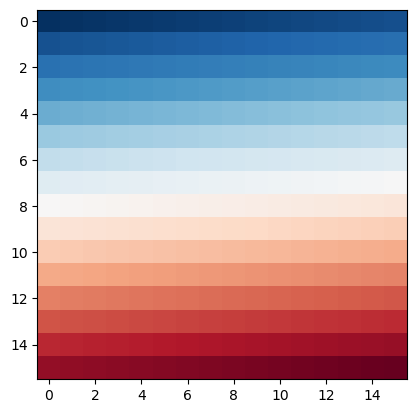

In [29]:
plt.imshow(x[0],cmap='RdBu_r')

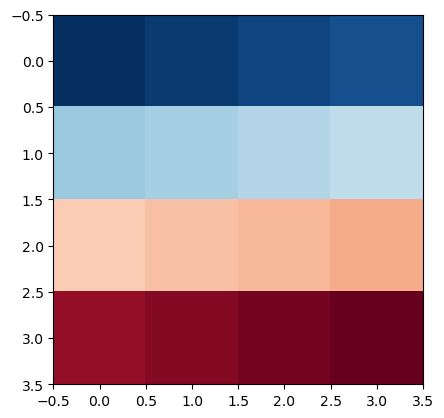

In [28]:
plt.imshow(t[0],cmap='RdBu_r')

In [36]:
t[0,1,3]

101.5

In [35]:
np.argwhere(t > 100)

array([[0, 1, 3],
       [0, 2, 0],
       [0, 2, 1],
       [0, 2, 2],
       [0, 2, 3],
       [0, 3, 0],
       [0, 3, 1],
       [0, 3, 2],
       [0, 3, 3],
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 2],
       [1, 0, 3],
       [1, 1, 0],
       [1, 1, 1],
       [1, 1, 2],
       [1, 1, 3],
       [1, 2, 0],
       [1, 2, 1],
       [1, 2, 2],
       [1, 2, 3],
       [1, 3, 0],
       [1, 3, 1],
       [1, 3, 2],
       [1, 3, 3],
       [2, 0, 0],
       [2, 0, 1],
       [2, 0, 2],
       [2, 0, 3],
       [2, 1, 0],
       [2, 1, 1],
       [2, 1, 2],
       [2, 1, 3],
       [2, 2, 0],
       [2, 2, 1],
       [2, 2, 2],
       [2, 2, 3],
       [2, 3, 0],
       [2, 3, 1],
       [2, 3, 2],
       [2, 3, 3],
       [3, 0, 0],
       [3, 0, 1],
       [3, 0, 2],
       [3, 0, 3],
       [3, 1, 0],
       [3, 1, 1],
       [3, 1, 2],
       [3, 1, 3],
       [3, 2, 0],
       [3, 2, 1],
       [3, 2, 2],
       [3, 2, 3],
       [3, 3, 0],
       [3, 3, 1],
       [3,